# Perform a nuclear segmentation on the DAPI staining using cellpose 2

In [52]:
import imageio as io
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import tifffile
from tqdm.notebook import tqdm
import pathlib
from cellpose import models, core
import json

xenium_path = 'data'

DEVELOPMENT = os.getenv('DEVELOPMENT')

## Read in Xenium DAPI

In this part we import the DAPI OME TIFF, create a max projection of the different layers and downsample the image slightly.

In [11]:
def read_dapi_image(path: str, downscale_factor: int = 2) -> np.ndarray:
    img_fpath = pathlib.Path(os.path.join(path, 'morphology_mip.ome.tif'))
    tif = tifffile.TiffFile(img_fpath)
    img = tif.asarray()
    if DEVELOPMENT:
        print(img.shape)
        img = img[10000:12000,10000:12000]
    return downscale_image(img, downscale_factor=downscale_factor)

def downscale_image(img: np.ndarray, downscale_factor: int = 2) -> np.ndarray:
    # Calculate the amount of padding needed for each axis
    pad_height = (downscale_factor - img.shape[0] % downscale_factor) % downscale_factor
    pad_width = (downscale_factor - img.shape[1] % downscale_factor) % downscale_factor

    # Pad the array with zeros
    img = np.pad(img, ((0, pad_height), (0, pad_width)), mode='constant')
    return img


In [12]:
maxed_xenium = read_dapi_image(xenium_path, downscale_factor=1)

(37471, 36995)


In [13]:
maxed_xenium.shape

(2000, 2000)

## Run cellpose

Here, we use the pretrained model to perform a nuclear segmentation with cellpose.

    This part takes A LOT of memory. Make sure you have at least 200 free Gb for a 35000 x 35000 pixel area.

I'm putting the model in the models folder with all the notebooks

In [16]:
def run_cellpose(img: np.ndarray, model_path: str) -> (np.ndarray, np.ndarray, np.ndarray):
    use_GPU = core.use_gpu()
    model = models.CellposeModel(gpu=use_GPU, pretrained_model= model_path  )
    channels = [0,0]
    masks, flows, styles = model.eval([img], channels=channels, diameter=model.diam_labels,flow_threshold=0, cellprob_threshold=0)
    return (masks, flows, styles)


In [17]:
masks, flows, styles = run_cellpose(
    maxed_xenium,
    model_path = r'models/CP_20230726_134214'
)

Plot and save segmentation

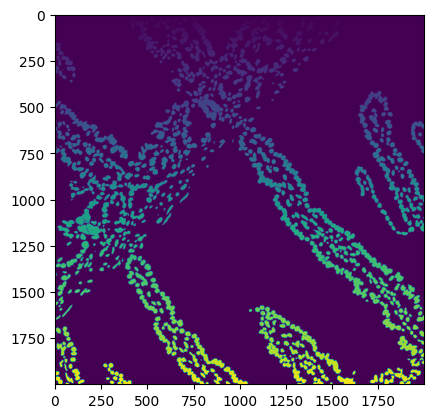

In [18]:
if DEVELOPMENT:
    plt.imshow(masks[0])

## Add the new segmentation to the transcripts.csv

In [25]:
detected_transcripts = pd.read_csv(os.path.join(xenium_path, 'transcripts.csv.gz'))
detected_transcripts

,transcript_id,cell_id,overlaps_nucleus,feature_name,x_location,y_location,z_location,qv,fov_name,nucleus_distance
0,281479271677952,blkojlhj-1,1,Il6st,5416.9960,7312.7207,23.650414,9.836952,AA11,0.000000
1,281479271677953,bllclphh-1,0,Btg1,5416.6377,7347.3647,28.401129,24.753258,AA11,0.000000
2,281479271677954,bllfepmg-1,0,BLANK_0475,5416.9414,7372.2280,27.940466,13.155691,AA11,0.295662
3,281479271677956,bllbneof-1,0,Btg1,5418.3380,7339.8390,26.742002,34.658360,AA11,1.078862
4,281479271677958,blnppina-1,0,Upp1,5418.1960,7422.2850,27.949463,12.276199,AA11,1.351240
...,...,...,...,...,...,...,...,...,...,...
39152009,281857229250720,kclapfho-1,1,H2-Ab1,1228.2498,5310.0645,22.278816,40.000000,X3,0.000000
39152010,281857229250721,kchcokhc-1,1,Itga6,1228.3702,5337.0303,19.963636,9.337701,X3,0.000000
39152011,281857229250723,kdgcfpof-1,0,Sorbs2,1228.2836,5596.2856,20.868147,11.698507,X3,2.252740
39152012,281857229250724,kckpimih-1,0,H2-Ab1,1228.4943,5290.2620,24.118523,29.458923,X3,2.623117


Get the pixel to um conversion

In [24]:
def get_pixel_size(path: str) -> float:
    file = open(os.path.join(path, "experiment.xenium"))
    experiment = json.load(file)
    pixel_size = experiment['pixel_size']
    return pixel_size

pixel_size = get_pixel_size(xenium_path)
pixel_size

0.2125

In [39]:
detected_transcripts['x_location_pixels'] = detected_transcripts.x_location.values*(1/pixel_size)
detected_transcripts['y_location_pixels'] = detected_transcripts.y_location.values*(1/pixel_size)

if DEVELOPMENT:
    detected_transcripts = detected_transcripts[
        (detected_transcripts['x_location_pixels'] > 10000) &
        (detected_transcripts['x_location_pixels'] < 12000) &
        (detected_transcripts['y_location_pixels'] > 10000) &
        (detected_transcripts['y_location_pixels'] < 12000)
    ].copy()
    detected_transcripts['x_location_pixels'] = detected_transcripts['x_location_pixels'] - 10000
    detected_transcripts['y_location_pixels'] = detected_transcripts['y_location_pixels'] - 10000

In [40]:
detected_transcripts

,transcript_id,cell_id,overlaps_nucleus,feature_name,x_location,y_location,z_location,qv,fov_name,nucleus_distance,x_location_pixels,y_location_pixels
8494128,281586645861737,cpacngni-1,1,Btg1,2129.2476,2174.6950,19.170973,40.000000,S5,0.000000,19.988706,233.858824
8494142,281586645861751,cogjphch-1,1,Btg1,2131.6218,2165.0486,21.152256,39.036083,S5,0.000000,31.161412,188.464000
8494145,281586645861754,cogjphch-1,1,Btg1,2131.9033,2164.3347,18.110502,32.050343,S5,0.227454,32.486118,185.104471
8494151,281586645861760,cogkdegm-1,1,Inpp4b,2133.1885,2171.4973,19.509867,31.352299,S5,0.000000,38.534118,218.810824
8494155,281586645861764,cpaehibo-1,0,Upp1,2133.7285,2179.2273,15.551867,40.000000,S5,1.314697,41.075294,255.187294
...,...,...,...,...,...,...,...,...,...,...,...,...
15478080,281642480991100,cmmmeeej-1,0,Cxcl10,2439.6643,2385.8235,20.257566,15.185481,T5,0.355970,1480.773176,1227.404706
15478081,281642480991101,cmmnadpn-1,1,Ifnlr1,2439.5024,2365.0620,18.176727,31.631592,T5,0.000000,1480.011294,1129.703529
15478083,281642480991103,cmmnacgf-1,0,Guca2a,2439.8237,2402.2244,21.764610,29.682630,T5,0.679467,1481.523294,1304.585412
15478086,281642480991107,cmmmmfol-1,1,Axin2,2440.3560,2410.5986,20.988522,23.632353,T5,0.000000,1484.028235,1343.993412


In [51]:
detected_cells = masks[0][detected_transcripts.y_location_pixels.values.astype(int), detected_transcripts.x_location_pixels.values.astype(int)]
detected_transcripts['cell_id'] = detected_cells
detected_transcripts['overlaps_nucleus'] = (detected_cells > 0).astype(int)
detected_transcripts

,transcript_id,cell_id,overlaps_nucleus,feature_name,x_location,y_location,z_location,qv,fov_name,nucleus_distance,x_location_pixels,y_location_pixels,cell_id_new,overlaps_nucleus_new
8494128,281586645861737,155,1,Btg1,2129.2476,2174.6950,19.170973,40.000000,S5,0.000000,19.988706,233.858824,155,1
8494142,281586645861751,0,0,Btg1,2131.6218,2165.0486,21.152256,39.036083,S5,0.000000,31.161412,188.464000,0,0
8494145,281586645861754,0,0,Btg1,2131.9033,2164.3347,18.110502,32.050343,S5,0.227454,32.486118,185.104471,0,0
8494151,281586645861760,140,1,Inpp4b,2133.1885,2171.4973,19.509867,31.352299,S5,0.000000,38.534118,218.810824,140,1
8494155,281586645861764,0,0,Upp1,2133.7285,2179.2273,15.551867,40.000000,S5,1.314697,41.075294,255.187294,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15478080,281642480991100,0,0,Cxcl10,2439.6643,2385.8235,20.257566,15.185481,T5,0.355970,1480.773176,1227.404706,0,0
15478081,281642480991101,833,1,Ifnlr1,2439.5024,2365.0620,18.176727,31.631592,T5,0.000000,1480.011294,1129.703529,833,1
15478083,281642480991103,0,0,Guca2a,2439.8237,2402.2244,21.764610,29.682630,T5,0.679467,1481.523294,1304.585412,0,0
15478086,281642480991107,977,1,Axin2,2440.3560,2410.5986,20.988522,23.632353,T5,0.000000,1484.028235,1343.993412,977,1


In [53]:
detected_transcripts.to_csv("transcripts_cellpose.csv")